после просмотра презентации настало время практики 🙌

In [1]:
# установка библиотеки
# ! pip3 list
! pip3 install sklearn

  Using cached sklearn-0.0-py2.py3-none-any.whl
You should consider upgrading via the '/Users/Alexey.Zhebel/IdeaProjects/CompLing/venv/bin/python -m pip install --upgrade pip' command.


# Naive Bayes (Наивный Байес)

Давайте сделаем простую классификацию писем на "спам/не спам". Например, на [этих данных](https://www.kaggle.com/uciml/sms-spam-collection-dataset)



In [1]:
# ячейка импортов

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm

# from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
! ls

class1.ipynb spam.csv


In [5]:
# читаем данные

data = pd.read_csv('spam.csv', encoding='utf-16') # обратите внимание на кодировку
data.head(10)

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   
5  spam  FreeMsg Hey there darling it's been 3 week's n...        NaN   
6   ham  Even my brother is not like to speak with me. ...        NaN   
7   ham  As per your request 'Melle Melle (Oru Minnamin...        NaN   
8  spam  WINNER!! As a valued network customer you have...        NaN   
9  spam  Had your mobile 11 months or more? U R entitle...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
5        NaN        NaN  
6        NaN        NaN  
7        NaN        NaN  
8        NaN        NaN  
9        NaN        NaN

In [16]:
# Почистим датафрейм

data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)

data = data.rename(columns={"v1": "spam", "v2": "content"})

# display(data)
data.head(10)

spam                                            content
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...

давайте посчитаем распределение спама/не спама

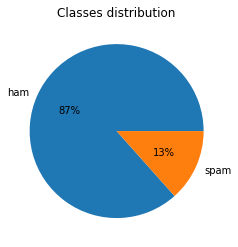

In [19]:
classes =pd.value_counts(data["spam"])

classes.plot(kind = 'pie',  autopct='%0.f%%')
# про string formatting https://realpython.com/python-string-formatting/

plt.title("Classes distribution")

plt.ylabel('')

plt.show()

**Анализ данных**

Давайте найдем частоты слов в сообщениях (отдельно для подкорпуса спама и не-спама). Для будущего алгоритма, слова будут признаками (features)

Для этого используем Counter из collections.

In [22]:
c = Counter(" ".join(data[data['spam']=='ham']["content"]).lower().split()).most_common(50)
print(c)

[('i', 2172), ('you', 1665), ('to', 1544), ('the', 1113), ('a', 1046), ('u', 874), ('and', 845), ('in', 786), ('my', 741), ('is', 710), ('me', 584), ('of', 518), ('for', 496), ('that', 442), ('it', 440), ('have', 433), ('your', 413), ('but', 413), ('are', 405), ('so', 399), ('not', 381), ('on', 379), ('at', 372), ("i'm", 369), ('can', 356), ('if', 346), ('do', 342), ('will', 331), ('be', 325), ('we', 297), ('get', 293), ('just', 286), ('2', 284), ('&lt;#&gt;', 276), ('when', 270), ('with', 269), ('how', 245), ('up', 243), ('go', 235), ('ur', 235), ('what', 235), ('all', 231), ('got', 227), ('this', 226), ('or', 226), ('no', 225), ('.', 222), ('like', 221), ('was', 221), ('call', 215)]


In [23]:
# заберем все слова по условию, заджойним в строку, разобьем по пробелам, возьмем топ-20
count1 = Counter(" ".join(data[data['spam']=='ham']["content"]).lower().split()).most_common(20) 
df1 = pd.DataFrame.from_dict(count1) # новый дф
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})

# тот же набор операций для второго подкорпуса
count2 = Counter(" ".join(data[data['spam']=='spam']["content"]).lower().split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count"})

display(df1,df2)

words in non-spam  count
0                  i   2172
1                you   1665
2                 to   1544
3                the   1113
4                  a   1046
5                  u    874
6                and    845
7                 in    786
8                 my    741
9                 is    710
10                me    584
11                of    518
12               for    496
13              that    442
14                it    440
15              have    433
16              your    413
17               but    413
18               are    405
19                so    399

words in spam  count
0             to    682
1              a    373
2           call    342
3           your    263
4            you    252
5            the    204
6            for    201
7             or    188
8           free    180
9              2    169
10            is    152
11            ur    144
12            on    141
13           txt    136
14          have    135
15          from    127
16           and    122
17             u    117
18          text    112
19        mobile    109

очень много "шума", давайте избавимся от стоп-слов. Используем [эту функцию](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) из sklearn 

In [24]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')

In [30]:
data["content"]

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will �_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: content, Length: 5572, dtype: object

### пример на маленькой матрице

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
corpus = ['This is the the first document.','Is this document my second document?']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
display(X.toarray())

v2 = TfidfVectorizer()
Y = v2.fit_transform(corpus)
print(vectorizer.get_feature_names())
display(Y.toarray())

['document', 'first', 'is', 'my', 'second', 'the', 'this']


array([[1, 1, 1, 0, 0, 2, 1],
       [2, 0, 1, 1, 1, 0, 1]])

['document', 'first', 'is', 'my', 'second', 'the', 'this']


array([[0.27867523, 0.39166832, 0.27867523, 0.        , 0.        ,
        0.78333663, 0.27867523],
       [0.63402146, 0.        , 0.31701073, 0.44554752, 0.44554752,
        0.        , 0.31701073]])

### идем дальше

In [33]:
X = f.fit_transform(data["content"])
# print(f.get_feature_names()) # посмотрим на признаки

display(X.shape)
display(X.toarray())

(5572, 8357)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

метод ```.fit_transform()``` выучивает обучающие данные и возвращает матрицу формата "документ-термин" для всего датасета

Сейчас у нас 8404 признака (по числу уникальных слов в корпусе). Новый признак  j  в ряду i  равен 1 если слово j  появляется в тексте i . В ином случае значение признака = 0

**давайте попробуем предсказать:** окажется ли письмо спамом или не спамом

Следует помнить о двух нежелательных вариантах:

- спам-письмо классифицируется как нормальное (False Negative)
- обычное письмо классифицируется как спам (False positive).
(какой вариант хуже?)

Сначала, представим значения spam/ham как числовые (1,0) 

In [34]:
data.head(10)

spam                                            content
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...

Затем разделим данные на обучающую и тестовую выборку [этой функцией](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [35]:
data["spam"]=data["spam"].map({'spam':1,'ham':0}) # в первой колонке переименуем значения 'spam' в 1  и 'ham' в 0

data.head(10)

spam                                            content
0     0  Go until jurong point, crazy.. Available only ...
1     0                      Ok lar... Joking wif u oni...
2     1  Free entry in 2 a wkly comp to win FA Cup fina...
3     0  U dun say so early hor... U c already then say...
4     0  Nah I don't think he goes to usf, he lives aro...
5     1  FreeMsg Hey there darling it's been 3 week's n...
6     0  Even my brother is not like to speak with me. ...
7     0  As per your request 'Melle Melle (Oru Minnamin...
8     1  WINNER!! As a valued network customer you have...
9     1  Had your mobile 11 months or more? U R entitle...

Создадим новые переменные:
- X_train - кусочек матрицы "документ/термин", который мы "отдадим" алгоритму для обучения
- X_test - кусочек матрицы "документ/термин", на котором будем проверять, как алгоритм сработал 
- y_train - кусочек датафрейма с текстами, который мы отдадим для обучения
- y_test -  кусочек датафрейма с текстами, на котором будем проверять, как алгоритм сработал 

In [38]:
# новые переменные
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['spam'], test_size=0.2, random_state=50)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
sum(y_test == 1)

(4457, 8357) (1115, 8357) (4457,) (1115,)


161

алгоритмов наивного байеса несколько, мы возьмем [Multinomial NB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

[дополнительная информация про Naive Bayes](https://nlp.stanford.edu/IR-book/pdf/13bayes.pdf)

Так как алгоритм быстрый, попробуем несколько вариантов с разным параметром регуляризации α *([что такое α ?](https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf))*

Затем для каждого проверим Precision, Recall и Accuracy

In [39]:
list_alpha = np.arange(1/100000, 20, 0.11) 
#возьмем лист равномерно распределенных значений от 1/100000 до 20(можно выбрать другие числа,эти были выбраны экспериментально)


score_train = np.zeros(len(list_alpha)) # задали пустые списки по длине изначального листа
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0

In [40]:
len(list_alpha)

182

In [41]:
for alpha in list_alpha: # для каждого значения в списке альф
    bayes = naive_bayes.MultinomialNB(alpha=alpha) # используем модель
    bayes.fit(X_train, y_train) # тренируем модель
    
    score_train[count] = bayes.score(X_train, y_train) # итерируемся по индексу в листе, добавляем значения accuracy
    # score_train? 
    
    score_test[count]= bayes.score(X_test, y_test)
    # score_test ? 
    
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    
    count = count + 1 # после одной итерации, делаем новый шаг

посмотрим на результаты моделей в зависимости от альфы

In [43]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
print(matrix[:3])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])


display(models.head(10))

display(matrix.shape)

[[1.00000000e-05 9.97083240e-01 9.73094170e-01 9.00621118e-01
  9.11949686e-01]
 [1.10010000e-01 9.96634508e-01 9.78475336e-01 9.44099379e-01
  9.10179641e-01]
 [2.20010000e-01 9.95961409e-01 9.78475336e-01 9.50310559e-01
  9.05325444e-01]]


alpha  Train Accuracy  Test Accuracy  Test Recall  Test Precision
0  0.00001        0.997083       0.973094     0.900621        0.911950
1  0.11001        0.996635       0.978475     0.944099        0.910180
2  0.22001        0.995961       0.978475     0.950311        0.905325
3  0.33001        0.995737       0.982063     0.944099        0.932515
4  0.44001        0.995288       0.982063     0.944099        0.932515
5  0.55001        0.994840       0.981166     0.937888        0.932099
6  0.66001        0.995064       0.981166     0.937888        0.932099
7  0.77001        0.994840       0.979372     0.925466        0.931250
8  0.88001        0.994840       0.978475     0.919255        0.930818
9  0.99001        0.994840       0.977578     0.913043        0.930380

(182, 5)


а теперь давайте оставим модель с наивысшей test precision

In [45]:
best_index = models['Test Precision'].idxmax()
# best_index

display(best_index)

display(models.iloc[best_index])

53

alpha             5.830010
Train Accuracy    0.990128
Test Accuracy     0.976682
Test Recall       0.838509
Test Precision    1.000000
Name: 53, dtype: float64

Посмотрим модели с высоким test recall

In [20]:
models[models['Test Recall']>0.9].sort_values(by="Test Precision", ascending = False)


alpha  Train Accuracy  Test Accuracy  Test Recall  Test Precision
17  1.87001        0.993718       0.980269     0.900621        0.960265
16  1.76001        0.993493       0.980269     0.900621        0.960265
12  1.32001        0.994840       0.979372     0.900621        0.953947
15  1.65001        0.993493       0.979372     0.900621        0.953947
14  1.54001        0.994166       0.979372     0.900621        0.953947
13  1.43001        0.994615       0.979372     0.900621        0.953947
3   0.33001        0.995513       0.982960     0.950311        0.932927
6   0.66001        0.994840       0.981166     0.937888        0.932099
7   0.77001        0.994840       0.980269     0.931677        0.931677
8   0.88001        0.994840       0.979372     0.925466        0.931250
9   0.99001        0.994840       0.977578     0.913043        0.930380
11  1.21001        0.994840       0.976682     0.906832        0.929936
10  1.10001        0.994840       0.976682     0.906832        0.929936
4   0.44001        0.995288       0.982063     0.950311        0.927273
5   0.55001        0.994840       0.981166     0.944099        0.926829
0   0.00001        0.997756       0.976682     0.919255        0.919255
1   0.11001        0.996635       0.978475     0.944099        0.910180
2   0.22001        0.995961       0.978475     0.950311        0.905325

Давайте из них выберем те, у которых наибольшее accuracy

In [52]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()

print(models.iloc[best_index])

best_index = models[models['Test Precision']>0.9]['Test Accuracy'].idxmax()

print(models.iloc[best_index])

alpha             5.830010
Train Accuracy    0.990128
Test Accuracy     0.976682
Test Recall       0.838509
Test Precision    1.000000
Name: 53, dtype: float64
alpha             0.330010
Train Accuracy    0.995737
Test Accuracy     0.982063
Test Recall       0.944099
Test Precision    0.932515
Name: 3, dtype: float64


### сделаем предикшн

In [54]:
bayes = naive_bayes.MultinomialNB(alpha= 0.330010) # используем лучшую модель
bayes.fit(X_train, y_train) # тренируем алгоритм на данных

bayes.predict(X_test) # метод для предсказания

# сделаем датафрейм с колонками для настоящего класса и для предсказанного

new_df = pd.DataFrame(data = y_test)
new_df["predicted"]=bayes.predict(X_test) # добавляем новую колонку с предсказаниями

new_df

spam  predicted
3409     0          0
2103     0          0
2665     0          0
3239     0          0
1205     0          0
...    ...        ...
5020     0          0
2141     0          0
1265     0          0
4094     0          0
1839     0          0

[1115 rows x 2 columns]

давайте построим матрицу ошибок ([как работает матрица ошибок](https://en.wikipedia.org/wiki/Confusion_matrix))

In [55]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))


pd.DataFrame(data = m_confusion_test,
             columns = ['Predicted ham', 'Predicted spam'],
             index = ['Actual ham', 'Actual spam'])

Predicted ham  Predicted spam
Actual ham             943              11
Actual spam              9             152

Заметим, что так как мы определили лейбл spam как класс 1, наша табличка "перевернута" и начинается с True Negative (Actual ham x Predicted ham) 
Сколько сообщений получились False Positive? Сколько False Negative?

# Support Vector Machines (SVM, метод опорных векторов)

попробуем сделать ту же задачу, с алгоритмом SVM

In [24]:
list_C = np.arange(500, 2000, 100) #100000

score_train = np.zeros(len(list_C))
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(X_train, y_train)
    score_train[count] = svc.score(X_train, y_train)
    score_test[count]= svc.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, svc.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, svc.predict(X_test))
    count = count + 1 

посмотрим на 10 первых моделей и их метрики:

In [25]:
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

C  Train Accuracy  Test Accuracy  Test Recall  Test Precision
0   500.0             1.0       0.970404     0.801242        0.992308
1   600.0             1.0       0.970404     0.801242        0.992308
2   700.0             1.0       0.970404     0.801242        0.992308
3   800.0             1.0       0.970404     0.801242        0.992308
4   900.0             1.0       0.970404     0.801242        0.992308
5  1000.0             1.0       0.970404     0.801242        0.992308
6  1100.0             1.0       0.970404     0.801242        0.992308
7  1200.0             1.0       0.970404     0.801242        0.992308
8  1300.0             1.0       0.970404     0.801242        0.992308
9  1400.0             1.0       0.970404     0.801242        0.992308

выберем модель с лучшим test precision

In [26]:
best_index = models['Test Precision'].idxmax()

display(models.iloc[best_index, :])

C                 500.000000
Train Accuracy      1.000000
Test Accuracy       0.970404
Test Recall         0.801242
Test Precision      0.992308
Name: 0, dtype: float64

In [27]:
# посмотрим на модели с почти 100% Precision

models[models['Test Precision']>0.99].head(5)

C  Train Accuracy  Test Accuracy  Test Recall  Test Precision
0  500.0             1.0       0.970404     0.801242        0.992308
1  600.0             1.0       0.970404     0.801242        0.992308
2  700.0             1.0       0.970404     0.801242        0.992308
3  800.0             1.0       0.970404     0.801242        0.992308
4  900.0             1.0       0.970404     0.801242        0.992308

In [28]:
best_index = models[models['Test Precision']>0.99]['Test Accuracy'].idxmax()
svc = svm.SVC(C=list_C[best_index])
svc.fit(X_train, y_train)
models.iloc[best_index, :]

C                 500.000000
Train Accuracy      1.000000
Test Accuracy       0.970404
Test Recall         0.801242
Test Precision      0.992308
Name: 0, dtype: float64

построим матрицу ошибок для SVM

In [29]:
m_confusion_test = metrics.confusion_matrix(y_test, svc.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

Predicted 0  Predicted 1
Actual 0          953            1
Actual 1           32          129